## M4 | Predictions on aggregated data

**Research question:** Predicting student reflection responses to the "How do you feel about your learning progress" question from their session interactions (response time, response correctness) and from the characteristics of the session (number of questions, feedback mode, time of the day, etc.)

In [215]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = '../data/processed' # Change accordingly

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, balanced_accuracy_score, roc_auc_score

In [2]:
# Run this cell if working on Colab
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Classtime'

Mounted at /content/drive


## Building our dataframe
We have generated a dataset of all participant answers with session information and question information such that these participants have answered the relevant feeling of learning question. We will aggregate these features into one row per participant and perform predictions on these.

In [3]:
# Load preprocessed dataset
df = pd.read_csv('{}/final.csv.gz'.format(DATA_DIR))

In [4]:
# Aggregate participants
df = df.groupby('participant_id').agg({
    'participant_id': 'first',
    'answer_time': ['min', 'max', 'mean'],
    'mode': 'first',
    'feedback_mode': 'first',
    'force_reflection': 'first',
    'timer': 'first',
    'is_solo': 'first',
    'video': 'mean',
    'image': 'mean',
    'correctness': ['min', 'max', 'mean'],
    'nth_answer': 'size', # Number of questions answered
    'response': 'first'
})

In [5]:
# Drop non-feature columns
df.drop(labels='participant_id', axis='columns', inplace=True)
# Flatten column index
df.columns = ["_".join(a) for a in df.columns.to_flat_index()]

In [6]:
df.head()

,answer_time_min,answer_time_max,answer_time_mean,mode_first,feedback_mode_first,force_reflection_first,timer_first,is_solo_first,video_mean,image_mean,correctness_min,correctness_max,correctness_mean,nth_answer_size,response_first
participant_id,,,,,,,,,,,,,,,
00000370-cbe8-4301-8728-320b552bf30e,1.004654e-06,0.000019,0.000007,0.0,0.0,0.0,0.041667,0.0,0.0,0.333333,1.0,1.0,1.000000,12,happy
00000873-7e4a-455a-bf42-08a68ace7d75,3.557573e-07,0.000643,0.000055,0.0,0.0,0.0,0.024368,0.0,0.0,0.000000,0.0,1.0,0.833333,12,happy
0000308e-9964-4dca-9fe0-62b6df2e61c8,2.491412e-07,0.000006,0.000002,0.0,1.0,0.0,0.024368,0.0,0.0,0.000000,0.5,1.0,0.861667,6,neutral
0000445b-eeb4-4b70-854c-4ba2152ced50,4.505047e-07,0.000006,0.000002,0.0,1.0,0.0,0.024368,0.0,0.0,0.000000,0.0,1.0,0.583333,12,neutral
00004874-d34d-4629-9ccb-93390cdafbaa,3.725867e-07,0.000006,0.000002,0.0,1.0,0.0,0.024368,0.0,0.0,0.000000,0.0,1.0,0.416667,24,neutral


## Model training and prediction

In [7]:
# Target label
y = df.pop('response_first')
# Features
X = df.to_numpy()

To compare models, we will use accuracy as an evaluation metric. We also compare our model performances to a baseline which simply predicts the most frequent class ("happy” in our case), which gives an accuracy of about 0.5597.

#### Baseline

In [8]:
y.value_counts()

happy      740266
neutral    399063
upset      183322
Name: response_first, dtype: int64

In [9]:
print(f"Baseline accuracy = {y.value_counts()[0]/len(y):.4f}")

Baseline accuracy = 0.5597


In [71]:
pred = ['happy' for _ in range(len(y))]
print(f"Baseline balanced accuracy = {balanced_accuracy_score(y, pred):.4f}")

Baseline balanced accuracy = 0.3333


#### Classification
We first evaluate classification models on the prediction task

In [68]:
models = {
    'LR': LogisticRegression(random_state=123, n_jobs=-1),
    'SVM': LinearSVC(random_state=123, dual=False),
    'RF': RandomForestClassifier(random_state=123, n_jobs=-1)
}

scalers = {
    StandardScaler()
}

param_grid = {
    'LR': {
        'model__multi_class': ['ovr', 'multinomial'],
        'model__C': np.logspace(-4, 4, 20)
    },
    'SVM': {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-4, 4, 20)
    },
    'RF': {
        'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
}

In [ ]:
results_list = []
for scaler in scalers:
    for name in models.keys():
        print(scaler, name)
        model = models[name]
        params = param_grid[name]
        
        steps = [('scaler', scaler),
                 ('model', model)]
        pipeline = Pipeline(steps)
        scoring = {"Accuracy": 'accuracy', "Balanced": 'balanced_accuracy'}
        # Number of folds can be tuned
        search = GridSearchCV(pipeline, params, cv=5, scoring=scoring,
                              refit="Balanced", verbose=1)
        search.fit(X, y)
        results = (model, name, scaler, search.best_score_, search.best_params_, search.cv_results_)
        results_list.append(results)
results_df = pd.DataFrame(results_list, columns=['model', 'name', 'scaler', 'score', 'params', 'results']).sort_values('score', ascending=False)

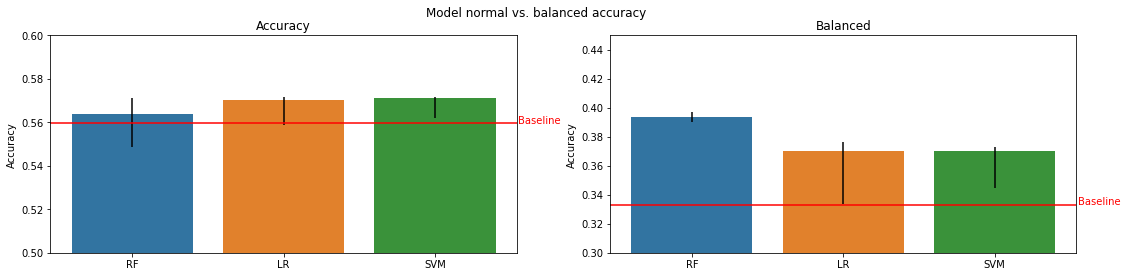

In [209]:
# Extract cross validation results
cv_results = pd.json_normalize(results_df.results).set_index(results_df.name)
cv_results['max_Balanced'] = cv_results.mean_test_Balanced.apply(lambda a: np.max(a))
cv_results['min_Balanced'] = cv_results.mean_test_Balanced.apply(lambda a: np.min(a))
cv_results['max_Accuracy'] = cv_results.mean_test_Accuracy.apply(lambda a: np.max(a))
cv_results['min_Accuracy'] = cv_results.mean_test_Accuracy.apply(lambda a: np.min(a))

# Barplot with min-max error bars
def min_max_bar(ax, title, y_lim, baseline):
    sns.barplot(data=cv_results[f'mean_test_{title}'], ax=ax, ci=None)
    ax.set_title(title)
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.axhline(baseline, color='red')
    ax.text(2.55, baseline, 'Baseline', color='red')
    ax.vlines([0, 1, 2], cv_results[f'min_{title}'], cv_results[f'max_{title}'], color='k')
    ax.set_xticklabels(cv_results.index)
    ax.set_ylabel('Accuracy')

fig, axs = plt.subplots(1, 2)
fig.suptitle('Model normal vs. balanced accuracy', x=1.25)
min_max_bar(axs[0], 'Accuracy', (0.5, 0.6), 0.5597)
min_max_bar(axs[1], 'Balanced', (0.3, 0.45), 0.3333)

# Adjust spacing between subplots
plt.subplots_adjust(right=2.5)
plt.show()

Random forests seem to have the best improvement of our considered models, which all improve upon the baseline in terms of normal and balanced accuracy. Random forests, however, seem to best perform in terms of balanced classification. That is, they perform better for all classes. In terms of normal accuracy, performance gains are only marginal (**note the small range of the y-axis**) compared to the computational cost.

#### Binary classification
Unfortunately, the multi-classification problem did not yield great predicting accuracy. Instead of predicting responses for each class, we will instead investigate predicting whether the student was happy or not (and turn the problem into a binary prediction problem).

In [211]:
y = y.map({'happy': 'happy', 'neutral': 'not_happy', 'upset': 'not_happy'})

In [222]:
# What was the baseline ROC AUC ?
roc = roc_auc_score(y.map({'happy': 1, 'not_happy': 0}).values, [1 for _ in range(len(y))])
print(f'Baseline ROC AUC = {roc:.4f}')

Baseline ROC AUC = 0.5000


In [223]:
results_list = []
for name in ['LR', 'RF']:
    print(name)
    model = models[name]
    params = param_grid[name]

    steps = [('model', model)]
    pipeline = Pipeline(steps)
    scoring = {"Accuracy": 'accuracy', "Balanced": 'balanced_accuracy', "AUC": 'roc_auc'}
    search = GridSearchCV(pipeline, params, cv=5, scoring=scoring, refit="AUC", verbose=1)
    search.fit(X, y)
    results = (model, name, scaler, search.best_score_, search.best_params_, search.cv_results_)
    results_list.append(results)

LR
Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF
Fitting 5 folds for each of 45 candidates, totalling 225 fits


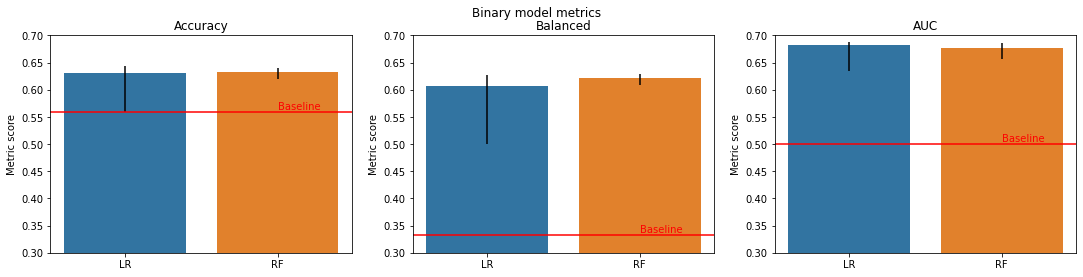

In [255]:
results_df = pd.DataFrame(results_list, columns=['model', 'name', 'scaler', 'score', 'params', 'results']).sort_values('score', ascending=False)
# Extract cross validation results
cv_results = pd.json_normalize(results_df.results).set_index(results_df.name)
for metric in ['Accuracy', 'Balanced', 'AUC']:
    cv_results[f'max_{metric}'] = cv_results[f'mean_test_{metric}'].apply(lambda a: np.max(a))
    cv_results[f'min_{metric}'] = cv_results[f'mean_test_{metric}'].apply(lambda a: np.min(a))

# Plot
fig, axs = plt.subplots(1, 3)
fig.suptitle('Binary model metrics', x=1.25)
min_max_bar(axs[0], 'Accuracy', (0.3, 0.7), 0.5597)
min_max_bar(axs[1], 'Balanced', (0.3, 0.7), 0.3333)
min_max_bar(axs[2], 'AUC', (0.3, 0.7), 0.5)

# Adjust spacing between subplots
plt.subplots_adjust(right=2.5)
plt.show()

In [258]:
print('Best scores:')
display(results_df[['name', 'score']])

Best scores:


,name,score
4,LR,0.686931
5,RF,0.685602


The binary prediction now seems to perform a lot better than the baseline, with accuracy metrics sitting between 0.6-0.65. The ROC area under curve score also sees a significant increase from the baseline 0.5 to values around 0.69.

### Linear Regression
As an extension, we will also evaluate predictive performance with a linear regression model by mapping our participant responses to some scale (-10=upset, 0=neutral, +10=happy for example) with an appropriate loss function (mean squared error or an adapted variant which does not penalize happy predictions that are greater than the happy mapping (respectively upset predictions less than the upset mapping)).